In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib.pylab as pl
plt.rcParams['figure.dpi'] = 75 # default for me was 75
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV #cross_validate
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import SCORERS, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
#from sklearn.model_selection import validation_curve

#conda install -c conda-forge shap
import shap
#Load JS visualisation code to Notebook
shap.initjs()

# NB! THis seed needs to be the same as in workbook 05a ...
# Only for comparison of Model purposes.
seed = 207

import pickle

In [2]:
# label to evaluate
labelToEval = 'cityScore'

# As I am generating all the data I need to extract a decent set of data for eventual testing.
featuresDataFilename = 'ModelInput/features.csv'
labelsDataFilename = 'ModelInput/labels.csv'
# All feature and label data I have available
featuresDf = pd.read_csv(featuresDataFilename)
print('Features: {}'.format(featuresDf.shape))
labelsDf = pd.read_csv(labelsDataFilename)[['cityId', labelToEval]]
print('  Labels: {}'.format(labelsDf.shape))

# Merge the features and labels so I can extract the various sets
dataDf = pd.merge(featuresDf, labelsDf, on='cityId', how='inner')
print('Combined: {}'.format(dataDf.shape))

# Start at 2nd column, i.e. exclude cityId
allX = pd.get_dummies(dataDf.iloc[:,2:len(featuresDf.columns)])
print('\n   All X: {}'.format(allX.shape))
allY = dataDf[labelToEval]
print('   All y: {}'.format(allY.shape))

# Create train and test split values. 
# train will be split further using the StratifiedKFold random search below for parameter Opt...
trainXouter, testX, trainYouter, testY = train_test_split(allX, allY, test_size=0.20, random_state=seed)

# When doing CV trainXouter and trainYouter will be split into trainX, valX and trainY, valY
# testX and testY is the "ultimate" checking dataset.

print('\n  testX: {}'.format(testX.shape))
print('  testY: {}'.format(testY.shape))
print('\n trainXouter: {}'.format(trainXouter.shape))
print(' trainYouter: {}'.format(trainYouter.shape))

Features: (502, 41)
  Labels: (502, 2)
Combined: (502, 42)

   All X: (502, 39)
   All y: (502,)

  testX: (101, 39)
  testY: (101,)

 trainXouter: (401, 39)
 trainYouter: (401,)


In [3]:
# Get the preferred model created in previous workbook
clf = pickle.load(open('./Models/20181219_103330.xgbmodel','rb'))
for param in clf.get_params():
    print('{:>20}: {:>10}'.format(param, str(clf.get_params()[param])))

          base_score:        0.5
             booster:     gbtree
   colsample_bylevel:          1
    colsample_bytree: 0.9679565829535766
               gamma:          0
       learning_rate:       0.05
      max_delta_step:          0
           max_depth:          1
    min_child_weight:          2
             missing:        nan
        n_estimators:        130
              n_jobs:          1
             nthread:       None
           objective: binary:logistic
        random_state:          0
           reg_alpha:          0
          reg_lambda:          1
    scale_pos_weight:          3
                seed:       None
              silent:       True
           subsample: 0.18394341516375318


In [4]:
predictedY = clf.predict(testX)
predictedYprobability = clf.predict_proba(testX)[:,1]

print('\nMetrics and confusion matrix for Test dataset')
print('')
print('  Accuracy:  {:.3f}'.format(accuracy_score(testY, predictedY)))
print('     Error:  {:.3f}'.format(1 - accuracy_score(testY, predictedY)))
print(' Precision:  {:.3f}'.format(precision_score(testY, predictedY)))
print('       AUC:  {:.3f}'.format(roc_auc_score(testY, predictedYprobability)))
print('')
print('    Recall:  {:.3f}'.format(recall_score(testY, predictedY)))
print('')
ct = pd.crosstab(
    pd.Series(testY.values, name='Actual'),
    pd.Series(predictedY, name='Predicted'),
    margins=True
)
print(ct)

predictedY = clf.predict(allX)
predictedYprobability = clf.predict_proba(allX)[:,1]

print('\nMetrics and confusion matrix for Whole dataset')
print('')
print('  Accuracy:  {:.3f}'.format(accuracy_score(allY, predictedY)))
print('     Error:  {:.3f}'.format(1 - accuracy_score(allY, predictedY)))
print(' Precision:  {:.3f}'.format(precision_score(allY, predictedY)))
print('       AUC:  {:.3f}'.format(roc_auc_score(allY, predictedYprobability)))
print('')
print('    Recall:  {:.3f}'.format(recall_score(allY, predictedY)))
print('')
ct = pd.crosstab(
    pd.Series(allY.values, name='Actual'),
    pd.Series(predictedY, name='Predicted'),
    margins=True
)
print(ct)



Metrics and confusion matrix for Test dataset

  Accuracy:  0.772
     Error:  0.228
 Precision:  0.536
       AUC:  0.753

    Recall:  0.600

Predicted   0   1  All
Actual                
0          63  13   76
1          10  15   25
All        73  28  101

Metrics and confusion matrix for Whole dataset

  Accuracy:  0.773
     Error:  0.227
 Precision:  0.527
       AUC:  0.791

    Recall:  0.648

Predicted    0    1  All
Actual                  
0          309   71  380
1           43   79  122
All        352  150  502


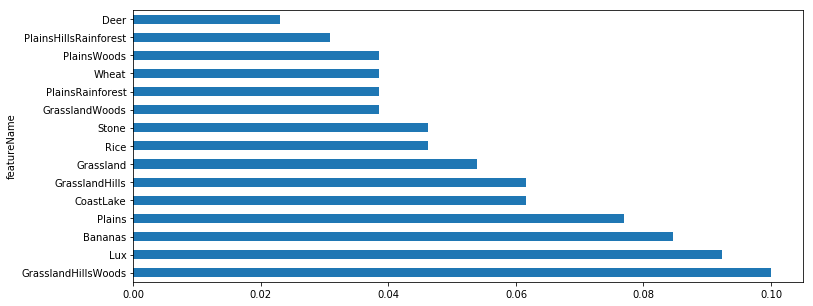

In [5]:
#type(clf.feature_importances_)
df = pd.DataFrame([allX.columns.values, list(clf.feature_importances_)]).T
df.columns=['featureName', 'featureScore']
df.sort_values('featureScore', ascending=False, inplace=True)
df.set_index('featureName', inplace=True)
df.iloc[:15].plot(kind='barh', legend=False, figsize=(12,5))

In [6]:
# Explain model's predictions using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(allX)

print('Base SHAP value: {:.4f}'.format(explainer.expected_value))

Base SHAP value: 0.3978


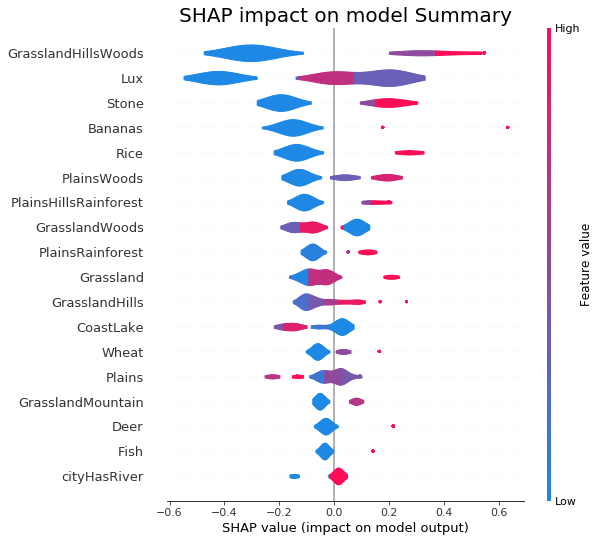

In [7]:
shap.summary_plot(shap_values, allX, plot_type='violin', max_display=18, show=False)
plt.title('SHAP impact on model Summary', fontsize=20)
plt.savefig('Images/SHAP_summary_01.png', bbox_inches='tight')
plt.show()

In [ ]:
# PER observation force plot ...
#shap.force_plot(explainer.expected_value, shap_values[2,:], allX.iloc[2,:])

In [ ]:
shap.summary_plot(shap_values, allX, plot_type="bar")

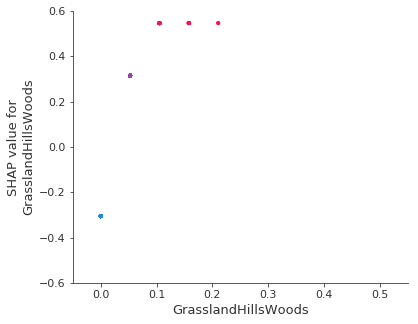

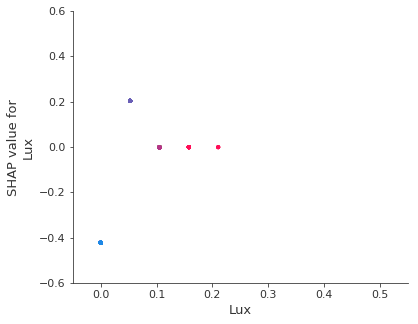

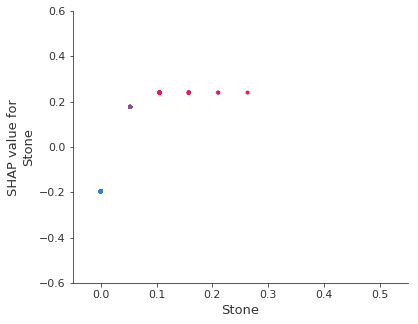

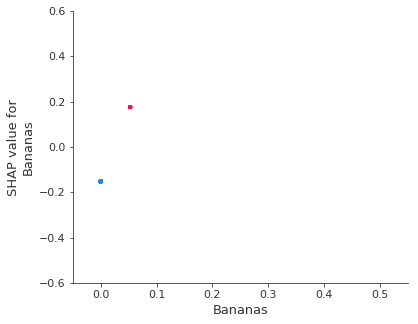

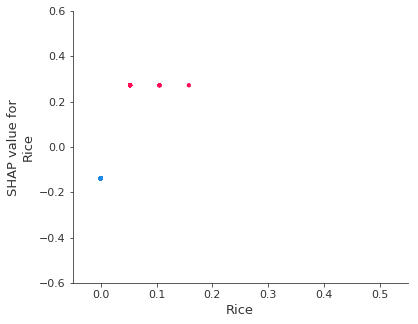

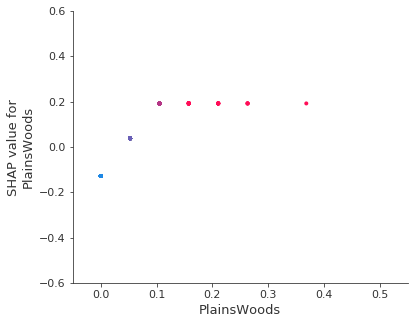

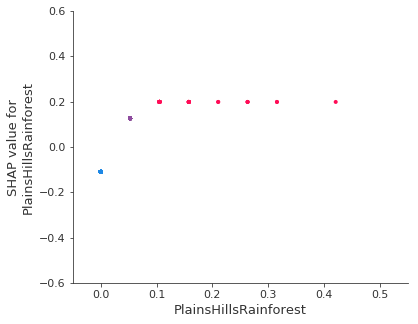

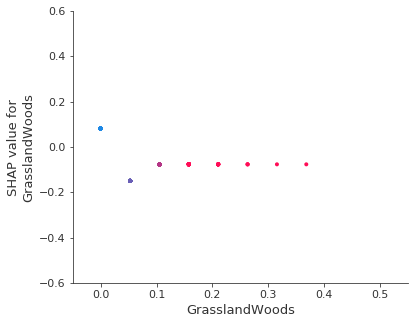

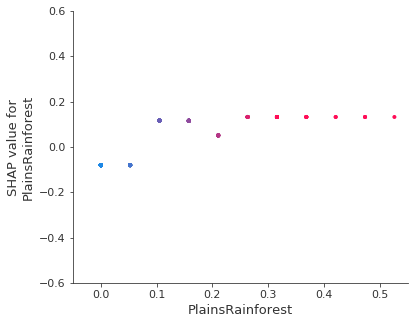

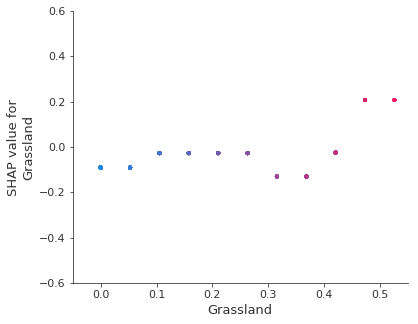

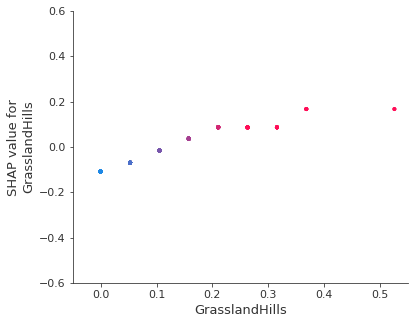

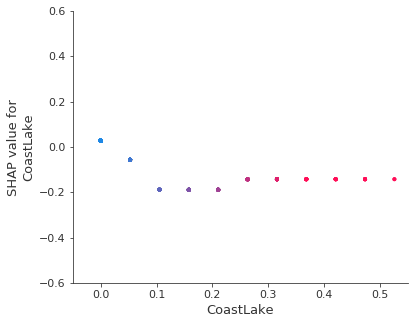

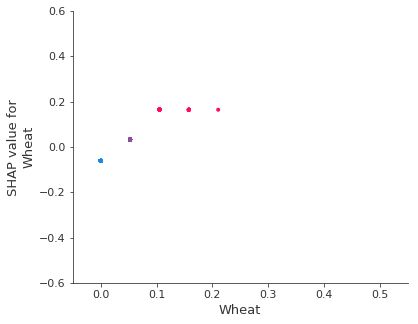

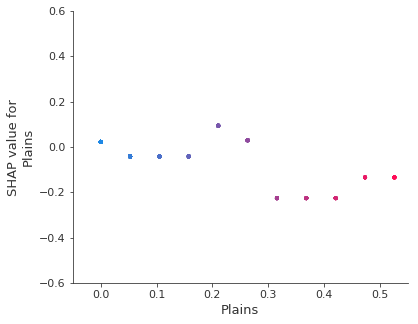

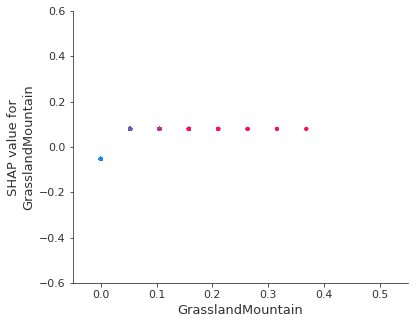

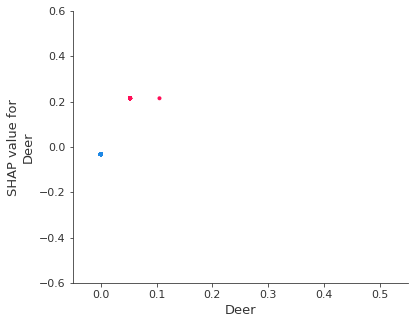

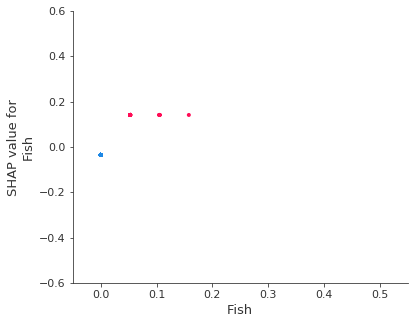

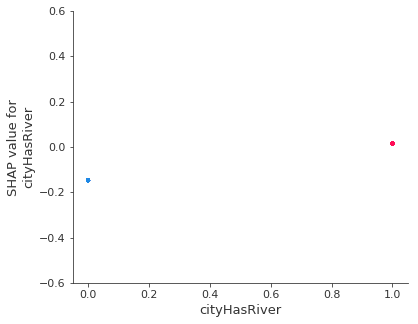

In [10]:
features= ['GrasslandHillsWoods', 'Lux', 'Stone', 'Bananas', 'Rice', 'PlainsWoods', 'PlainsHillsRainforest',
           'GrasslandWoods', 'PlainsRainforest', 'Grassland', 'GrasslandHills', 'CoastLake', 'Wheat', 
           'Plains', 'GrasslandMountain', 'Deer', 'Fish', 'cityHasRiver']
for feature in features:
    idx1 = allX.columns.get_loc(feature)
    idx2 = allX.columns.get_loc(feature)
    shap.dependence_plot(idx1, shap_values, allX, None, None, idx2, show=False)
    plt.ylim(-0.6,0.6)
    plt.xlim(-0.05,0.55)
    if feature == 'cityHasRiver':
        plt.xlim(-0.05, 1.05)
    plt.show()

In [ ]:
#shap.TreeExplainer(clf).shap_interaction_values(allX)
#shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(allX) #.iloc[:,:])
#shap.summary_plot(shap_interaction_values, allX)  #.iloc[:2000,:]

#shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(allX)
#shap.dependence_plot(
#    ("GrasslandHillsWoods", "GrasslandHillsWoods"),
#    shap_interaction_values, allX,
#    display_features=allX
#)

#    shap_interaction_values, X.iloc[:2000,:],
#    display_features=X_display.iloc[:2000,:]

Tile
Yield
Plains
1P1F
Grassland
2F
Plains Forest
2P1F
Plains Hill Forest
3P1F
Plains Rainforest
2F1P
Plains Hills Rainforest
2F2P
Grassland Hill
1P2F
Grassland Forest Hill
2P2F
Desert
-
Desert Hill
1P
Snow
-
Snow Hill
1P
Tundra
1F
Tundra Woods
1F1P
Tundra Hill
1F1P
Tundra Wooded Hills
1F2P


In [ ]:
display(xgb.to_graphviz(clf, num_trees=0))
display(xgb.to_graphviz(clf, num_trees=1))
display(xgb.to_graphviz(clf, num_trees=2))
display(xgb.to_graphviz(clf, num_trees=3))